In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('./utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
import rft_reconstruct_traj as rft
from scipy.io import loadmat

In [2]:
mat=h5py.File('../data/Foraging_N2/PNAS2011-DataStitched.mat','r')
refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate

n_worms = len(tseries_w)

# FigS3 - alpha optimization

In [3]:
indices = np.arange(1000)
opt_alphas_sample = []
kw_sims_all = []
t0_sims_all = []
for idx in indices:
    f = h5py.File('../data/rft_optimize_alpha/opt_alphas_{}.h5'.format(idx),'r')
    opt_alphas = np.array(f['opt_alphas'])
    kw_sims = np.array(f['kw_sims'],dtype=int)
    t0_sims = np.array(f['t0_sims'],dtype=int)
    f.close()
    opt_alphas_sample.append(opt_alphas)
    kw_sims_all.append(kw_sims)
    t0_sims_all.append(t0_sims)
kw_sims_all = np.hstack(kw_sims_all)
t0_sims_all = np.hstack(t0_sims_all)

In [4]:
opt_alphas_all = np.hstack(opt_alphas_sample)
sel = np.logical_and(opt_alphas_all>0,opt_alphas_all<1000)
median,cil,ciu = stats.bootstrap(opt_alphas_all[sel],n_times=1000,median=True)

In [5]:
median,cil,ciu

(29.84497,
 masked_array(data=[29.267405843734743],
              mask=[False],
        fill_value=1e+20),
 masked_array(data=[30.551990365982057],
              mask=[False],
        fill_value=1e+20))

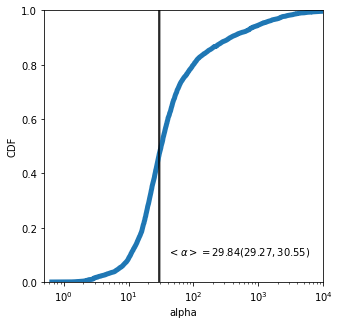

In [6]:
plt.figure(figsize=(5,5))
x,y = stats.cumulative_dist(opt_alphas_all,lims=(0,100000))
plt.plot(x,y,lw=5)
plt.axvline(median,c='k')
plt.axvspan(cil[0],ciu[0],alpha=.25,color='k')
plt.xlim(5e-1,1e4)
plt.ylim(0,1)
plt.text(4e1,.1,r'$<\alpha> = {:.2f}({:.2f},{:.2f})$'.format(median,cil[0],ciu[0]))
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('CDF')
# plt.savefig('opt_alphas.pdf')
# plt.yscale('log')
# plt.xscale('log')
plt.show()

In [7]:
eigenworms_matrix = np.loadtxt('../data/Foraging_N2/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in tseries_w])

mat = loadmat('../data/Foraging_N2/shapes.mat')
theta_ensemble = np.array(mat['theta_ensemble'],dtype=float)
stepper_to_mm = 788
wormCM = ma.array(mat['wormCm'][:,::2,:],dtype=float)/stepper_to_mm
wormCM[wormCM==0] = ma.masked
headTail_theta_w = np.array(mat['wormHeadTailTheta'],dtype=float)
pix_to_mm = 405
wormLength = ma.array(mat['wormLength'],dtype=float)/pix_to_mm
wormLength[wormLength==0]=ma.masked    

L_w = np.array([np.median(wormLength[kw].compressed())for kw in range(n_worms)])

#flip back worms that were previously flipped
theta_ensemble = ma.masked_invalid(theta_ensemble)
theta_ensemble[theta_ensemble==0]= ma.masked
mean_diff = np.array([ma.abs(thetas_w[kw]-theta_ensemble[kw][::2]).mean() for kw in range(n_worms)])
mean_neg_diff = np.array([ma.abs(thetas_w[kw]+theta_ensemble[kw][::2]).mean() for kw in range(n_worms)])
flipped_worms_neg = np.arange(n_worms)[np.array(mean_neg_diff)<.5]
flipped_worms = np.arange(n_worms)[np.array(mean_diff)>1]
for kw in flipped_worms:
    thetas_w[kw] = -thetas_w[kw]

In [8]:
opt_alphas_all[:10]

array([2.0624666e+01, 1.3805017e+01, 3.6207199e+01, 3.0792189e+01,
       5.9510889e+02, 3.5266457e+01, 3.4910706e+01, 3.7485867e+01,
       1.5106716e+01, 4.2331198e+15], dtype=float32)

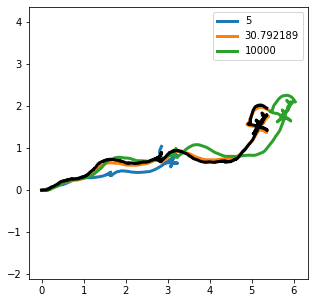

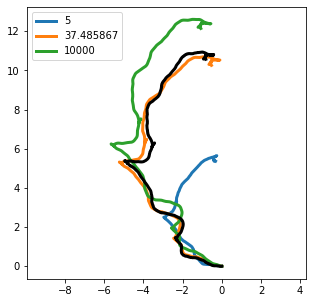

In [9]:
indices = [3,7]

for idx in indices:
    kw=kw_sims_all[idx]
    t0 = t0_sims_all[idx]
    opt_alpha = opt_alphas_all[idx]
    wsize = int(100*frameRate)
    tf = t0+wsize
    angleArray = thetas_w[kw][t0:tf].T
    XCM_data = wormCM[kw][t0:tf,0]
    YCM_data = wormCM[kw][t0:tf,1]
    X_data_c = np.vstack([XCM_data-XCM_data[0],YCM_data-YCM_data[0]]).T
    
    L = L_w[kw]
    theta = -angleArray
    ds = L/(theta.shape[0])
    skel = rft.get_skels(theta,L)
    X = skel[:,:,0]
    Y = skel[:,:,1]

    XCM, YCM, UX, UY, UXCM, UYCM, TX, TY, NX, NY, I, OMEG = rft.get_RBM(skel,L,ds,dt)
    DX, DY, ODX, ODY, VX, VY, Xtil, Ytil, THETA = rft.subtractRBM(X, Y, XCM, YCM, UX, UY, UXCM, UYCM, OMEG, dt)
    TX,TY = rft.lab2body(TX, TY, THETA)
    VX,VY = rft.lab2body(VX, VY, THETA)
    
    
    R = lambda theta: np.array(((np.cos(theta), -np.sin(theta)), (np.sin(theta), np.cos(theta))))

    plt.figure(figsize=(5,5))
    alpha_range = [5,opt_alpha,10000]
    for alpha in alpha_range: 
        RBM = rft.posture2RBM(TX,TY,Xtil,Ytil,VX,VY,L,I,ds,alpha)
        XCM_recon,YCM_recon,THETA_recon = rft.integrateRBM(RBM,dt,THETA)
        Xrecon = np.vstack([XCM_recon,YCM_recon]).T
        rot_angle_range = np.linspace(0,2*np.pi,1000)
        dists = np.array([np.linalg.norm(X_data_c-Xrecon.dot(R(alpha)),axis=1).max() for alpha in rot_angle_range])
        Xrot = Xrecon.dot(R(rot_angle_range[np.argmin(dists)]))
        plt.plot(Xrot[:,0],Xrot[:,1],label=str(alpha),lw=3)
    plt.plot(X_data_c[:,0],X_data_c[:,1],c='k',lw=3)
    plt.legend()
    plt.axis('equal')
    # plt.savefig('example_alpha_trajs_{}.pdf'.format(idx))
    plt.show()

# Fig4 - MSDs

In [10]:
msd_sims_w=[]
msd_data_w=[]
for kw in range(n_worms):
    f = h5py.File('../data/msd_sims/msds_sims_w_{}.h5'.format(kw),'r')
    alpha = np.array(f['alpha'])[0]
    msd_sims = np.array(f['mu_sims'])
    msd_data = np.array(f['mu_data'])
    lags = np.array(f['lags'],dtype=int)
    f.close()
    msd_sims_w.append(msd_sims)
    msd_data_w.append(msd_data)

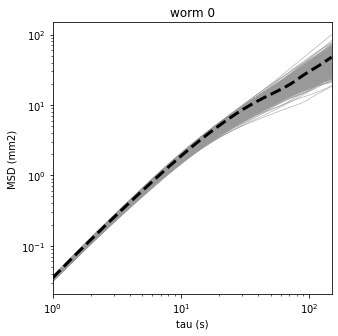

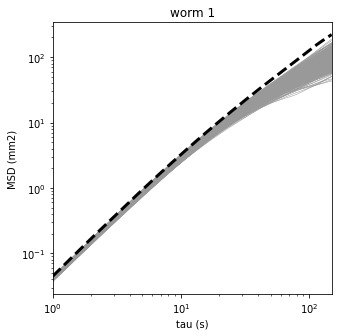

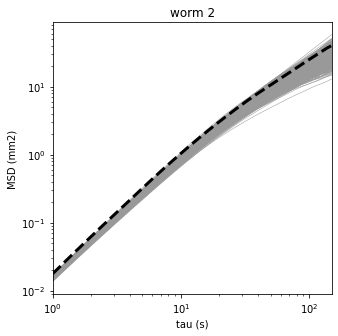

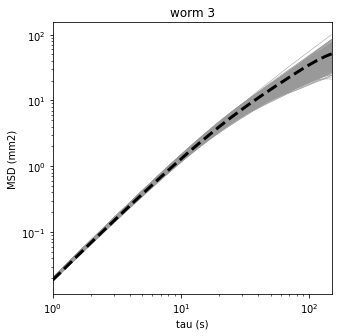

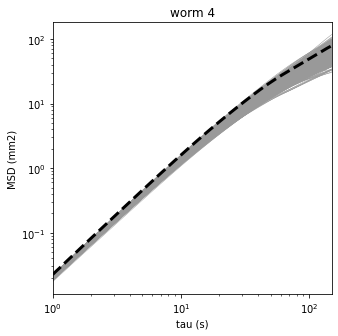

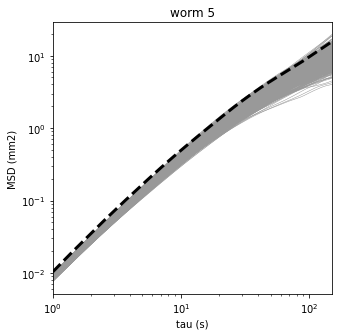

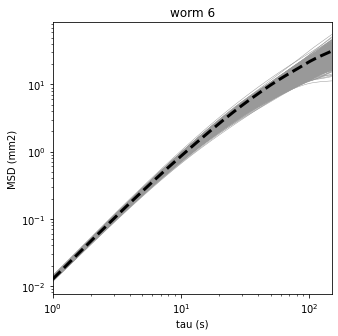

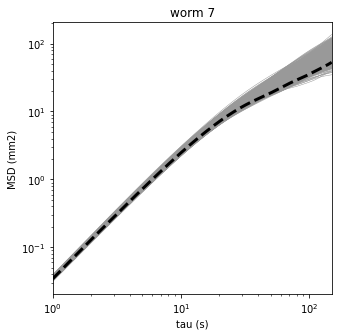

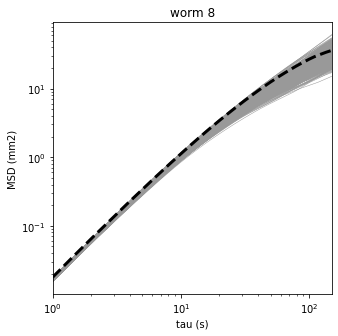

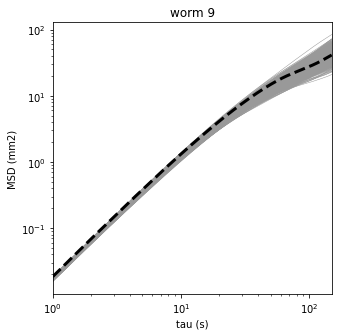

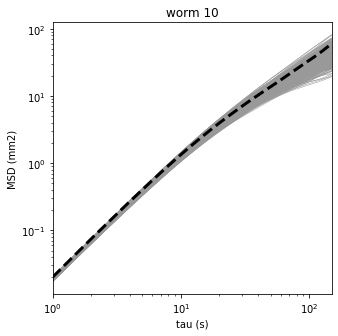

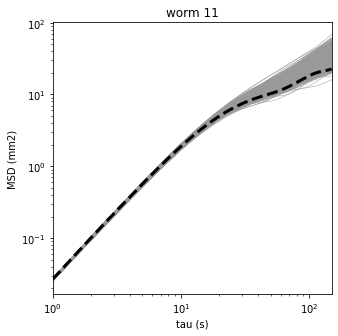

In [11]:
for kw in range(n_worms):
    msd_data = msd_data_w[kw]
    msd_sims = msd_sims_w[kw]
    plt.figure(figsize=(5,5))
    plt.title('worm {}'.format(kw))
    plt.plot(lags*dt,msd_sims.T,c='.6',lw=.5)
    plt.plot(lags*dt,msd_data,c='k',lw=3,ls='--')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('MSD (mm2)')
    plt.xlabel('tau (s)')
    plt.xlim(1,150)
#     plt.ylim(1e-2,3e2)
#     plt.savefig('msds_lines_w_{}.pdf'.format(kw))
    plt.show()

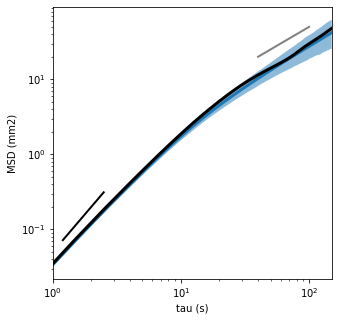

In [12]:
kw=0
msd_data = msd_data_w[kw]
msd_sims = msd_sims_w[kw]
mean,cil,ciu = msd_sims.mean(axis=0),np.percentile(msd_sims,2.5,axis=0),np.percentile(msd_sims,97.5,axis=0)
plt.figure(figsize=(5,5))
plt.plot(lags*dt,mean,lw=3)
plt.fill_between(lags*dt,cil,ciu,alpha=.5)
plt.plot(lags*dt,msd_data,c='k',lw=3)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('MSD (mm2)')
plt.xlabel('tau (s)')
plt.xlim(1,150)
x = np.linspace(1.2,2.5)
plt.plot(x,.05*x**2,c='k',lw=2)
x = np.linspace(40,100)
plt.plot(x,.5*x,c='gray',lw=2)
#     plt.ylim(1e-2,3e2)
# plt.savefig('msds_lines_w_{}.pdf'.format(kw))
plt.show()

In [13]:
def displacements(x, lags=500):
    if type(lags) is int:
        lags = np.arange(lags)
    disps=[]
    for i, lag in enumerate(lags):
        if lag==0:
            mu[i] = 0
        elif lag >= x.shape[0]:
            mu[i] = ma.masked
        else:
            x0 = x[lag:,:].copy()
            x1 = x[:-lag,:].copy()
            displacements = ma.sum((x0 - x1)**2,axis=1)
            disps.append(displacements)
    return disps

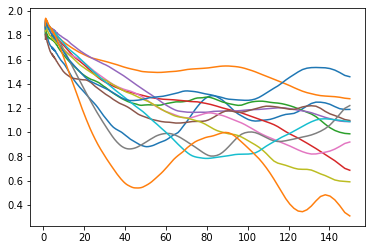

In [14]:
for kw in range(12):
    plt.plot(lags[1:]*dt,np.gradient(np.log10(msd_data_w[kw][1:]),np.log10(lags[1:]*dt)))
plt.show()

In [15]:
stride=1
diffs2 = []
diffs1= [ ]
x=np.log10(lags[1:]*dt)
for kw in range(len(tseries_w)):
    y = np.log10(msd_data_w[kw][1:])
    dy_dx = np.diff(y)/np.diff(x)
    x1 = (x[1:]+x[:-1])/2
    diffs1.append(dy_dx)
    d2y_dx2 = np.diff(dy_dx)/np.diff(x1)
    x2 = (x1[1:]+x1[:-1])/2
    diffs2.append(d2y_dx2)

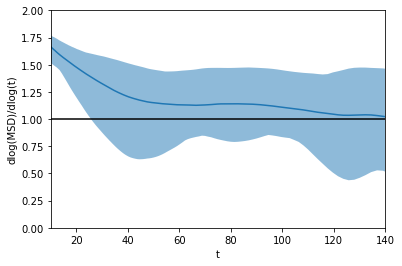

In [16]:
plt.plot(10**x1,np.nanmean(diffs1,axis=0))#,marker='o')
plt.fill_between(10**x1,np.nanpercentile(diffs1,2.5,axis=0),np.nanpercentile(diffs1,97.5,axis=0),alpha=.5)
plt.axhline(1,c='k')
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel('dlog(MSD)/dlog(t)')
plt.xlim(10,140)
plt.ylim(0,2)
plt.xlabel('t')
# plt.savefig('diffusive_regime.pdf')
plt.show()

In [17]:
n_samples=100
indices = np.arange(len(lags))[np.logical_and(lags*dt>60,lags*dt<100)]

deff_sim_w=np.zeros((n_worms,3))
deff_data_w=np.zeros((n_worms,3))
for kw in range(n_worms):
    disps=displacements(wormCM[kw],lags)
    bootstrapped_deff = []
    for ks in range(n_samples):
        msd_sample = np.hstack([disps[kl][np.random.randint(0,len(disps[kl]),len(disps[kl]))].mean() for kl in range(len(lags))])
        m,b = np.polyfit(lags[indices]*dt,msd_sample[indices],1)
        bootstrapped_deff.append(m)

    msd_data = np.hstack([disps[kl].mean() for kl in range(len(lags))])
    deff_data,b = np.polyfit(lags[indices]*dt,msd_data[indices],1)
    deff_cil_data = np.percentile(bootstrapped_deff,2.5)
    deff_ciu_data = np.percentile(bootstrapped_deff,97.5)
    
    msd_sims = msd_sims_w[kw]
    deff_sim,b = np.polyfit(lags[indices]*dt,msd_sims.mean(axis=0)[indices],1)
    deff_sample = []
    for ks in range(len(msd_sims)):
        m,b = np.polyfit(lags[indices]*dt,msd_sims[ks][indices],1)
        deff_sample.append(m)
    deff_cil_sim = np.percentile(deff_sample,2.5)
    deff_ciu_sim = np.percentile(deff_sample,97.5)
    
    deff_sim_w[kw] = [deff_sim,deff_cil_sim,deff_ciu_sim]
    deff_data_w[kw] = [deff_data,deff_cil_data,deff_ciu_data]
    print(kw,deff_data,deff_sim,deff_cil_sim,deff_ciu_sim)

0 0.3387452929668246 0.28759121078774846 0.14947552880320245 0.45652367288537865
1 1.707735388809398 0.7000984793046919 0.38691143620842955 1.067493770125251
2 0.2965942600942205 0.20916864580618233 0.11484358674890031 0.31901037684425315
3 0.4063657055698713 0.3352294740063311 0.17927469187383793 0.5135629526257852
4 0.5497819555001011 0.4499732807142036 0.25321448517505 0.6687500553338914
5 0.10313630399881869 0.06864010186375308 0.035171175084850216 0.10565034022771497
6 0.2399288706705688 0.19483311726355065 0.11090984197018969 0.29655581966093575
7 0.317606745251448 0.48826305457984426 0.26289583316027776 0.784404105417363
8 0.2828971208189237 0.2273380498002032 0.12749525353980326 0.35073369427242135
9 0.23559188512475845 0.30166387820830826 0.17022105820514244 0.45067231927103135
10 0.41074224854555846 0.3015031220604007 0.17211575949574004 0.4601545161095953
11 0.1709259795255271 0.22949891751098994 0.1090132628427816 0.37050371694219814


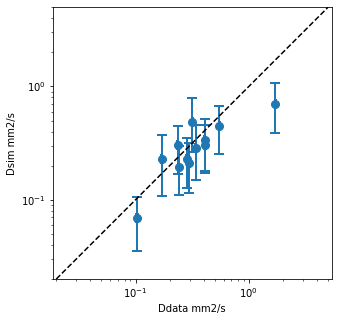

In [18]:
plt.figure(figsize=(5,5))
plt.errorbar(deff_data_w[:,0],deff_sim_w[:,0],xerr = [deff_data_w[:,0]-deff_data_w[:,1],deff_data_w[:,2]-deff_data_w[:,0]],yerr = [deff_sim_w[:,0]-deff_sim_w[:,1],deff_sim_w[:,2]-deff_sim_w[:,0]],fmt='o',capsize=5,ms=8,lw=2,capthick=2)
# plt.errorbar(deff_data_w[:,0],deff_shuffled_sim_w[:,0],xerr = [deff_data_w[:,0]-deff_data_w[:,1],deff_data_w[:,2]-deff_data_w[:,0]],yerr = [deff_shuffled_sim_w[:,0]-deff_shuffled_sim_w[:,1],deff_shuffled_sim_w[:,2]-deff_shuffled_sim_w[:,0]],fmt='o',capsize=5,ms=8,lw=2,capthick=2)

xrange = np.linspace(2e-2,5)
plt.plot(xrange,xrange,c='k',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.axis('equal')
plt.xlim(2e-2,5)
plt.ylim(2e-2,5)
plt.xlabel('Ddata mm2/s')
plt.ylabel('Dsim mm2/s')
# plt.savefig('deffs.pdf')
plt.show()

In [19]:
kw=6
f = h5py.File('../data/centroid_sims_opt_alpha/example_sims_w_{}.h5'.format(kw),'r')
X_sims = np.array(f['X_sims'])
f.close()

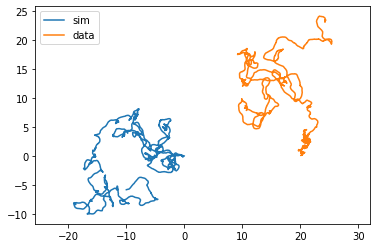

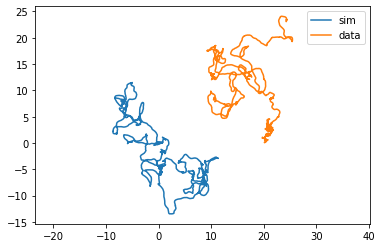

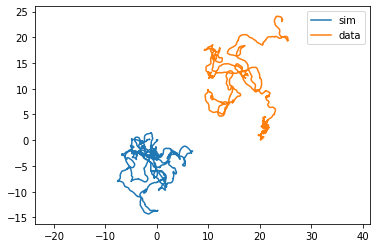

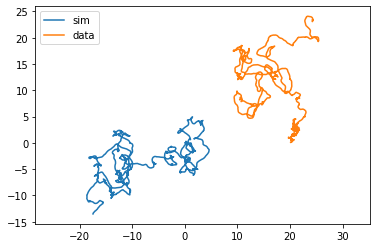

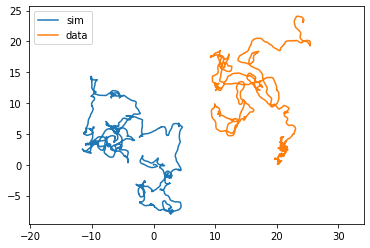

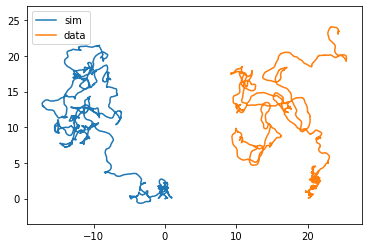

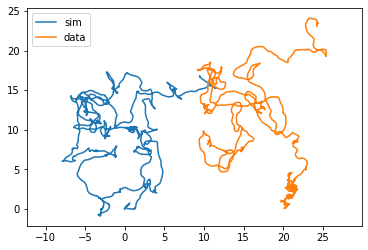

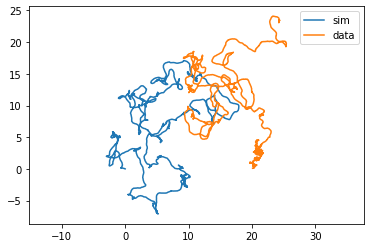

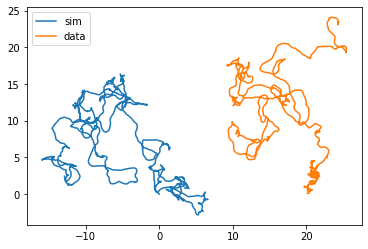

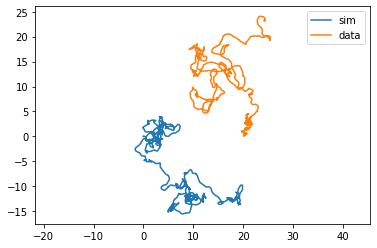

In [20]:
for ks in range(len(X_sims)):
    plt.plot(X_sims[ks][:,0],X_sims[ks][:,1],label='sim')
    plt.plot(wormCM[kw][:,0]+20,wormCM[kw][:,1],label='data')
    plt.axis('equal')
    plt.legend()
#     plt.savefig('example_centroid_sim_{}.pdf'.format(ks))
    plt.show()